In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
from src.model.mask_unet import UNet
from src.libs.preprocessing import DataLoader

In [2]:
post_name = "20241221_084543"

In [3]:
model_loaded = UNet(
    id_experiment=0
)  # Assurez-vous que la classe UNet est définie ou importée
model_loaded.eval()
# Charger les poids sauvegardés
model_loaded.load_state_dict(
    torch.load(
        f"output/model_unet_{post_name}.pth",
        weights_only=True,
        map_location=torch.device("cpu"),
    )
)
model_loaded.eval()
print("Model loaded!")

Model loaded!


In [4]:
path_test_x = "data/input/denoising/test"
path_test_y = "data/input/voice_origin/test"
data_loader = DataLoader(path_x=path_test_x, path_y=path_test_y)
harmonized_data = data_loader.get_harmonized_data()

Import summary:
- Data imported successfully!
- Number of noised samples: 782
- Number of original samples: 782
- Signal shapes in noised samples: [80000]
- Signal shapes in original samples: [80000]
- Frequencies in noised samples: [8000]
- Frequencies in original samples: [8000]
- Correspondance between both data sets: True.


# Audio

In [26]:
file_number = 5
test_x, test_y = harmonized_data.x[file_number], harmonized_data.y[file_number]

In [27]:
Audio(test_x, rate=harmonized_data.sampling_freq)

In [28]:
Audio(test_y, rate=harmonized_data.sampling_freq)

In [8]:
# spect_x = generate_spectrograms_resized(
#     torch.tensor(test_x)[None, :], "cpu", n_fft=2**10
# )
# spect_x.shape

# Utils spectrogram

In [29]:
def gen_spect(signal, n_fft=2**10):
    window = torch.ones(n_fft)
    spec = torch.stft(
        signal,
        n_fft=n_fft,
        window=window,
        return_complex=True,
    )
    magnitude = torch.abs(spec)
    phase = torch.angle(spec)

    magnitude_resized = torch.nn.functional.interpolate(
        magnitude.unsqueeze(0).unsqueeze(
            0
        ),  # Ajouter deux dimensions pour batch et channel
        size=(512, 128),
        mode="bilinear",
        align_corners=False,
    ).squeeze()  # Enlever les dimensions inutiles

    phase_resized = torch.nn.functional.interpolate(
        phase.unsqueeze(0).unsqueeze(
            0
        ),  # Ajouter deux dimensions pour batch et channel
        size=(512, 128),
        mode="bilinear",
        align_corners=False,
    ).squeeze()  # Enlever les dimensions inutiles

    return magnitude_resized, phase_resized

In [30]:
mag_spect_x, phase_spect_x = gen_spect(torch.tensor(test_x))

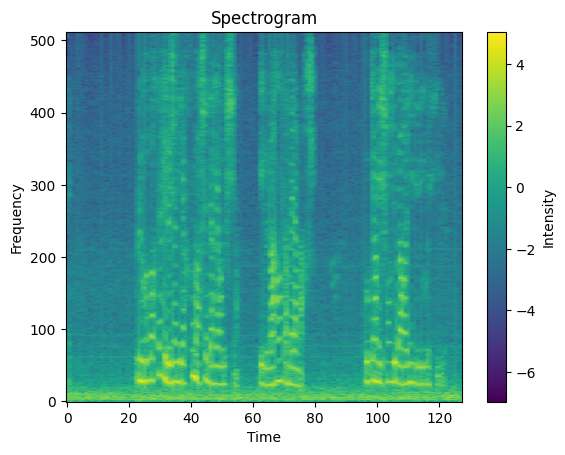

In [31]:
# Convertir le tenseur en un tableau numpy pour matplotlib
mag_spect_x_np = mag_spect_x.numpy()

# Afficher le spectrogramme avec un colormap
plt.imshow(np.log(mag_spect_x_np), aspect="auto", cmap="viridis", origin="lower")
plt.colorbar(label="Intensity")  # Ajouter une barre de couleur
plt.title("Spectrogram")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.show()

In [32]:
mag_spect_y, phase_spect_y = gen_spect(torch.tensor(test_y))

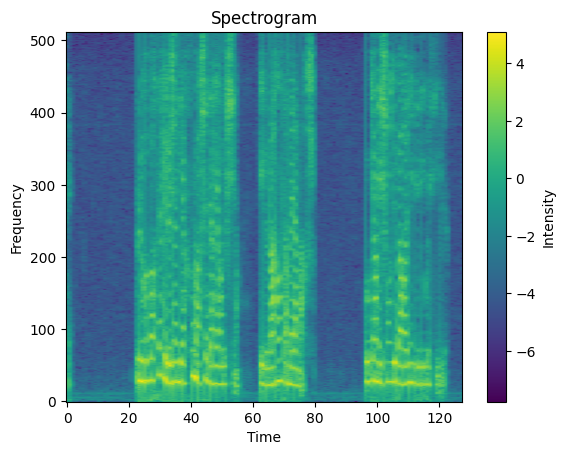

In [33]:
# Convertir le tenseur en un tableau numpy pour matplotlib
mag_spect_y_np = mag_spect_y.numpy()

# Afficher le spectrogramme avec un colormap
plt.imshow(np.log(mag_spect_y_np), aspect="auto", cmap="viridis", origin="lower")
plt.colorbar(label="Intensity")  # Ajouter une barre de couleur
plt.title("Spectrogram")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.show()

In [34]:
n_fft = 2**10
hop_length = 512
win_length = 1024


window = torch.ones(n_fft)
spec = torch.stft(
    torch.tensor(test_y),
    n_fft=n_fft,
    window=window,
    return_complex=True,
    hop_length=hop_length,
    win_length=n_fft,
)
print(spec.shape)

re_spec, im_spec = torch.real(spec), torch.imag(spec)

# Downsample

resized_re_spec = torch.nn.functional.interpolate(
    re_spec.unsqueeze(0).unsqueeze(0),  # Ajouter deux dimensions pour batch et channel
    size=(512, 128),
    mode="bilinear",
    align_corners=False,
).squeeze()  # Enlever les dimensions inutiles

resized_im_spec = torch.nn.functional.interpolate(
    im_spec.unsqueeze(0).unsqueeze(0),  # Ajouter deux dimensions pour batch et channel
    size=(512, 128),
    mode="bilinear",
    align_corners=False,
).squeeze()  # Enlever les dimensions inutiles

# Upsample

augmented_re_spec = torch.nn.functional.interpolate(
    resized_re_spec.unsqueeze(0).unsqueeze(0),
    size=spec.shape,
    mode="bilinear",
    align_corners=False,
)

augmented_im_spec = torch.nn.functional.interpolate(
    resized_im_spec.unsqueeze(0).unsqueeze(0),
    size=spec.shape,
    mode="bilinear",
    align_corners=False,
)
augmented_spec = (1j * augmented_im_spec + augmented_re_spec).squeeze()
print(augmented_spec.shape)

reconstructed_signal = torch.istft(
    augmented_spec,
    n_fft=n_fft,
    hop_length=hop_length,
    win_length=win_length,
    window=window,
    length=test_y.shape[0],
)

torch.Size([513, 157])
torch.Size([513, 157])


In [35]:
Audio(reconstructed_signal, rate=8000)

In [36]:
Audio(test_y, rate=8000)

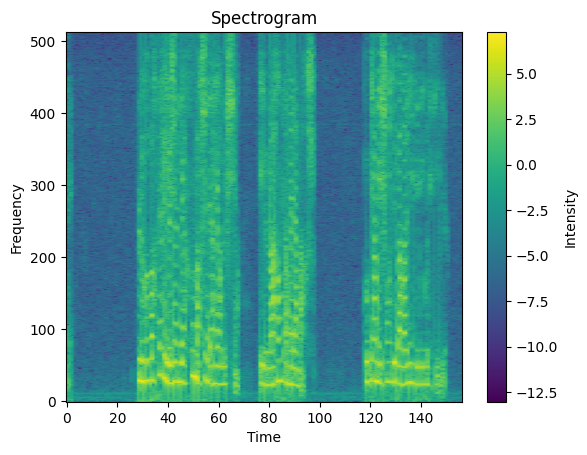

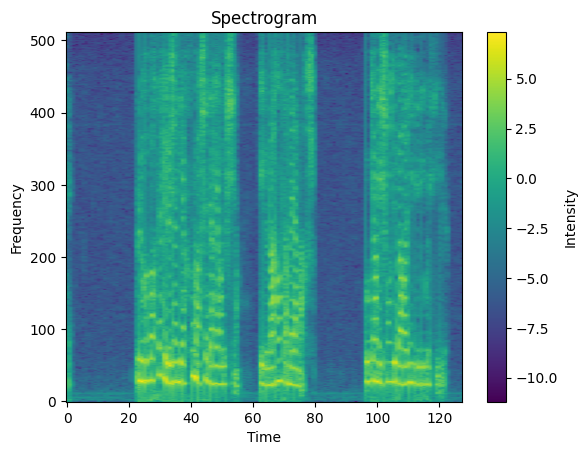

In [37]:
# Convertir le tenseur en un tableau numpy pour matplotlib
mag_spect_y_np = torch.abs(spec).numpy()

# Afficher le spectrogramme avec un colormap
plt.imshow(np.log2(mag_spect_y_np), aspect="auto", cmap="viridis", origin="lower")
plt.colorbar(label="Intensity")  # Ajouter une barre de couleur
plt.title("Spectrogram")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.show()

# Convertir le tenseur en un tableau numpy pour matplotlib
mag_spect_y_np = mag_spect_y.numpy()

# Afficher le spectrogramme avec un colormap
plt.imshow(np.log2(mag_spect_y_np), aspect="auto", cmap="viridis", origin="lower")
plt.colorbar(label="Intensity")  # Ajouter une barre de couleur
plt.title("Spectrogram")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.show()

In [38]:
reconstructed_signal = torch.istft(
    spec,
    n_fft=n_fft,
    hop_length=hop_length,
    win_length=win_length,
    window=window,
    length=test_y.shape[0],
)
Audio(reconstructed_signal, rate=8000)

Spectrogram Shape: torch.Size([513, 257])


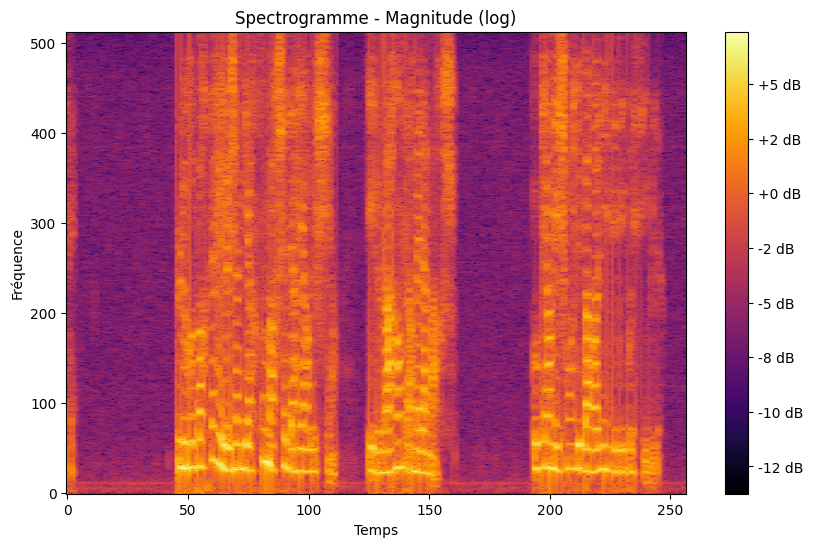

In [39]:
import torch
import matplotlib.pyplot as plt

# Exemple de signal (longueur 8000)
signal = torch.tensor(test_y)

# Paramètres pour la STFT
n_fft = 1024
hop_length = 312  # Ajustez pour obtenir un spectrogramme de taille 512x512
win_length = 1024
window = torch.ones(n_fft)

# Calcul du spectrogramme
spectrogram = torch.stft(
    signal,
    n_fft=n_fft,
    hop_length=hop_length,
    win_length=win_length,
    window=window,
    return_complex=True,
)

# Vérification de la taille du spectrogramme
print(f"Spectrogram Shape: {spectrogram.shape}")

# Convertir en magnitude et afficher
magnitude = spectrogram.abs()

plt.figure(figsize=(10, 6))
plt.imshow(magnitude.log2().numpy(), aspect="auto", cmap="inferno", origin="lower")
plt.title("Spectrogramme - Magnitude (log)")
plt.colorbar(format="%+2.0f dB")
plt.xlabel("Temps")
plt.ylabel("Fréquence")
plt.show()

In [40]:
def invert_spectrogram(
    spec, n_fft=1024, hop_length=512, win_length=1024, window=None, length=None
):
    if window is None:
        window = torch.ones(n_fft)

    # Inverse STFT (reconstruction du signal à partir du spectrogramme)
    reconstructed_signal = torch.istft(
        spec,
        n_fft=n_fft,
        hop_length=hop_length,
        win_length=win_length,
        window=window,
        length=length,  # Assurez-vous que la longueur est égale à celle du signal d'origine
    )
    return reconstructed_signal


# Inverser le spectrogramme
reconstructed_signal = invert_spectrogram(
    spectrogram,
    n_fft=n_fft,
    hop_length=hop_length,
    win_length=win_length,
    length=signal.shape[0],
)

# Afficher la forme du signal reconstruit
print(f"Reconstructed Signal Shape: {reconstructed_signal.shape}")

# Jouer le signal reconstruit (assurez-vous d'exécuter ce code dans un environnement qui supporte Audio, comme Jupyter)
Audio(reconstructed_signal.numpy(), rate=8000)

Reconstructed Signal Shape: torch.Size([80000])


In [41]:
(reconstructed_signal - test_y).abs().max()

/tmp/ipykernel_67928/3668745538.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  (reconstructed_signal - test_y).abs().max()


tensor(5.5511e-16, dtype=torch.float64)

In [42]:
import torch.nn.functional as F


def upsample_spectrogram(spectrogram: torch.Tensor) -> torch.Tensor:
    """
    Suréchantillonner un spectrogramme de taille (512, 256) à (513, 257).
    """
    # Ajouter une ligne de zéros pour obtenir la dimension (513, 256)
    spectrogram_upsampled = F.pad(
        spectrogram, (0, 1, 0, 0), value=0
    )  # Pad sur la colonne pour obtenir (512, 257)

    # Ajouter une colonne de zéros pour obtenir la dimension (513, 257)
    spectrogram_upsampled = F.pad(
        spectrogram_upsampled, (0, 0, 0, 1), value=0
    )  # Pad sur la ligne pour obtenir (513, 257)

    return spectrogram_upsampled

In [43]:
spectrogram_res = spectrogram[:-1, :-1]

spectrogram_aug = upsample_spectrogram(spectrogram_res)
print(spectrogram_aug.shape, spectrogram_res.shape)
reconstructed_signal_res = invert_spectrogram(
    spectrogram_aug,
    n_fft=n_fft,
    hop_length=hop_length,
    win_length=win_length,
    length=signal.shape[0],
)

# Afficher la forme du signal reconstruit
print(f"Reconstructed Signal Shape: {reconstructed_signal_res.shape}")

print((reconstructed_signal_res - reconstructed_signal).abs().std())

# Jouer le signal reconstruit (assurez-vous d'exécuter ce code dans un environnement qui supporte Audio, comme Jupyter)
Audio(reconstructed_signal_res.numpy(), rate=8000)

torch.Size([513, 257]) torch.Size([512, 256])
Reconstructed Signal Shape: torch.Size([80000])
tensor(0.0003, dtype=torch.float64)


In [47]:
model_loaded(spectrogram_res.float()[None, None, :]).shape

torch.Size([1, 1, 512, 256])